In [1]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
    """This data loader will download an aligned fasttext embedding given a two letter language code.
    More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
    def __init__(self, lang='en'):
        """Data loader"""
        self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
        cachefile = "cache_%s.npz" % lang
        if os.path.exists(cachefile):
            print("Loading cached data...", end="")
            t = time.time()
            data = np.load(cachefile)
            self.idx2token_ = list(data['idx2token'])
            self.vectors_ = data['vectors']
            print("done (%isec)" % (time.time()-t), flush=True)
        else:
            with urlopen(self._dataurl) as remote_file:
                get_decoded_line = lambda file: file.readline().decode('utf-8')
                self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
                self.idx2token_ = list()
                self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
                for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
                    textline = get_decoded_line(remote_file)
                    linedata = textline.split(' ')
                    self.idx2token_.append(linedata[0])
                    self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
            np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
        self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')


Loading cached data...done (10sec)


## Your analyzer
This is the analyzer. Your task is to finish this in line with the unit tests, the assignment text specifications, and the paper Bolukbasi (2016).

In [53]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class EmbeddingAnalyzer(object):
    def __init__(self, embedding):
        self.vectors_ = embedding.vectors_
        self.token2idx_ = embedding.token2idx_
        self.idx2token_ = embedding.idx2token_

    def __len__(self):
        """Gives the number of tokens in the embedding."""
        return len(self.idx2token_)

    def __getitem__(self, tokens):
        """Returns the vectors for a token or a list of tokens."""
        if isinstance(tokens, list):
            vecs = []
            for token in tokens:
                vecs.append(self.vectors_[self.token2idx_[token]])
            return np.array(vecs)
        else:
            return self.vectors_[self.token2idx_[tokens]].reshape(1,-1)

    def __contains__(self, token):
        """Allows a user query if a tokens is in the embedding."""
        return token in self.idx2token_


    def projection(self, direction, vectors):
        """The cosine similarity between a reference direction and a matrix of word vectors.
        direction:
          A vector
        vectors:
          A row matrix with word vectors"""
        return cosine_similarity(direction, vectors)

    def simple_analogy(self, pair, query, k=5):
        """Simple/Classic word analogy as: man - woman = king - queen"""
        
        semantic_diff = self.__getitem__(pair[0]) - self.__getitem__(pair[1])
        query_vec = self.__getitem__(query)
        result_vec = query_vec - semantic_diff
        
        best_match = []
        scored_vecs = [cosine_similarity(result_vec, vec.reshape(1,-1)) for vec in self.vectors_]
        for vec in sorted(scored_vecs, reverse=True)[:k]:
            best_match.append(self.idx2token_[scored_vecs.index(vec.ravel())])
            
        return best_match
    

    def similarity(self, token1, token2):
        """Returns the cosine similarity between two tokens."""
        vector1, vector2 = self.__getitem__(token1), self.__getitem__(token2)
        return cosine_similarity(vector1, vector2)

    def analogies(self, analogy_direction, tokens):
        """The more complex word analogy method"""
        pairs_final = []
        
        for tok1 in tokens:
            pairs = []
            pair_scores = []
            tok1_vec = self.__getitem__(tok1)
            
            for tok2 in tokens:
                tok2_vec = self.__getitem__(tok2)
                
                if euclidean_distances(tok1_vec, tok2_vec) <=1 and tok1 != tok2:
                    diff = tok1_vec - tok2_vec
                    pair_scores.append(cosine_similarity(analogy_direction, diff))                    
                else:
                    pair_scores.append(0)
                pairs.append((tok1, tok2))
                
            top_score = sorted(pair_scores, reverse=True)[0]
            top_idx = pair_scores.index(top_score)
            
            if pair_scores[top_idx] > 0:
                pairs_final.append(pairs[top_idx])
                
        return pairs_final

    
analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer

assert len(analyzer) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

## Word similarity

We should be able to meassure similarity as cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [5]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies. We can this of this as word a is to word b, as word c is to word d. Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

In [68]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


We can do this for capitols too.

$\overrightarrow{France} - \overrightarrow{Japan} \approx \overrightarrow{Paris} - \overrightarrow{x}$

In [69]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


Please try doing this for at least one other famous category (e.g. comparing adjectives).

## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [6]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
    professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of the anlayzer give us the ccosine similarity, we can see the direction of the projection by looking at its sign.

In [7]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

We create a woman-man direction.

In [8]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [9]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
    definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [10]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
    direction2 += analyzer[male.lower()]
    direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

We can plot the relation between genderedness in the data and human annotation.

<ipython-input-14-37f86a07c56d>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


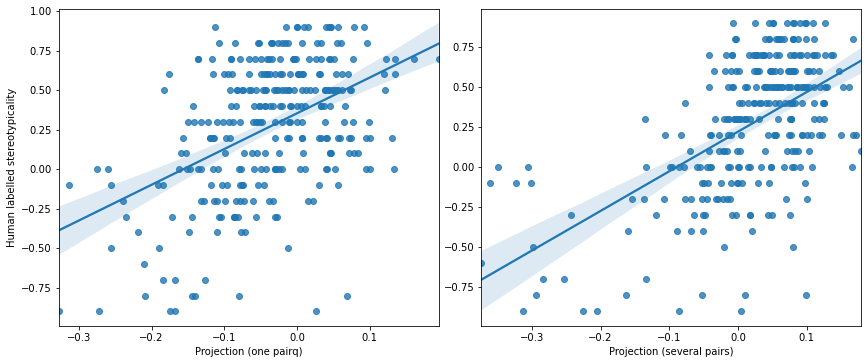

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pairq)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

<ipython-input-13-ad4edbf9ea6b>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


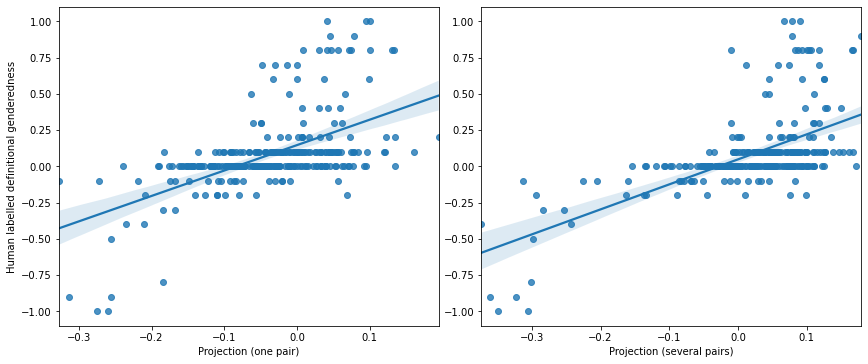

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

In [ ]:
# <ipython-input-85-ad4edbf9ea6b>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # fig.show()

## More analogies

The paper defines a more advanced procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [51]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 1
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actor', 'actress')]

In [52]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businesswoman'),
 ('actor', 'actress'),
 ('actress', 'waitress'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'protagonist'),
 ('advocate', 'campaigner'),
 ('aide', 'counselor'),
 ('alderman', 'solicitor'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'secretary'),
 ('analyst', 'columnist'),
 ('anthropologist', 'pediatrician'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'parishioner'),
 ('architect', 'painter'),
 ('artist', 'singer'),
 ('artiste', 'performer'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('athlete', 'swimmer'),
 ('attorney', 'paralegal'),
 ('author', 'novelist'),
 ('ballerina', 'actress'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'campaigner'),
 ('bartender', 'waitress'),
 ('biologist', 'pediatrician'),
 ('bishop', 'parishioner'),
 ('bookkeeper', 'waitress'),
 ('boss', 'bartender'),
 ('boxer', 'wrestler'),
 ('broadcaster', 'columnist'),
 ('broker', 'realtor'),
 ('businessman', '

I think the simple_analogy method was a little tricky because the way I used was not practical, the time complexity was high and took very long to get the final result. I was trying to find a better algorithm but I haven't found it. The final analogies method in the class took me most time, since I needed to read the paper, understand the logic behind it, and make it run as expected. It took me most time to understand the authors' ideas before coding. I also needed to be super sensitive to the shape of arrays in each step to make sure they could work as expected, so I used some reshape methods to guarantee that. Through this assginment, I learned how I could use word embeddings semantically with a class for future tasks. Another problem is that my matplotlib wouldn't work, although I tried many ways. One made the figure show separately from the notebook, so I didn't use it. All other ways kept reporting bugs. So I kept what was shown originally when my code ran.